In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn

import matplotlib.pyplot as plt
ACC_G = 9.81

In [2]:
def get_data(data_path: str) -> pd.DataFrame:
    df = pd.read_csv(data_path)
    processed_df = pd.DataFrame(
        {
            "roll_lataccel": np.sin(df["roll"].values) * ACC_G,
            "v_ego": df["vEgo"].values,
            "a_ego": df["aEgo"].values,
            "target_lataccel": df["targetLateralAcceleration"].values,
            "steer_command": -df[
                "steerCommand"
            ].values,  # steer commands are logged with left-positive convention but this simulator uses right-positive
        }
    )
    return processed_df

In [3]:
train_data = []
for i in range(19000):
  pd_frame = get_data(f'data/{i:05d}.csv')
  td = pd_frame[:100].values
  train_data.append(td)

train_data = np.array(train_data)


In [4]:
val_data = []
for i in range(19000, 20000):
  pd_frame = get_data(f'data/{i:05d}.csv')
  td = pd_frame[:100].values
  val_data.append(td)

val_data = np.array(val_data)

In [43]:
data_size = 10 # train_data.shape[0]

Xtr = torch.tensor(train_data[:data_size, :-1], dtype=torch.float32)# .reshape(-1, 5)
Ytr = torch.tensor(train_data[:data_size, 1:, 3:4], dtype=torch.float32)# .reshape(-1)

Xval = torch.tensor(val_data[:, :-1], dtype=torch.float32).reshape(-1, 5)
Yval = torch.tensor(val_data[:, 1:, 3:4], dtype=torch.float32).reshape(-1)



In [44]:
mean, std = Xtr.mean(dim=0), Xtr.std(dim=0)

In [45]:
# preprocessing
Xtr = (Xtr - mean) / std
Xval = (Xval - mean) / std

Ytr = (Ytr - mean[3:4]) / std[3:4]
Yval = (Yval - mean[3:4]) / std[3:4]

In [46]:
Xtr[0], Ytr[0]

(tensor([ 0.8439,  1.5069, -0.4775,  1.7904,  1.3905]), tensor(1.8805))

In [47]:
def get_batch(Xtr, Ytr, batch_size: int):
    idx = np.random.choice(Xtr.shape[0], batch_size)
    return Xtr[idx], Ytr[idx]

In [48]:
class LTVDynamicsModel(nn.Module):  # Linear Time-Varying Dynamics Model
    def __init__(self, layers=[64, 64]):
        super(LTVDynamicsModel, self).__init__()
        layers = [nn.Linear(3, layers[0]), nn.ReLU()] + [
            nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)
        ] + [nn.Linear(layers[-1], 3)]
        self.time_varying_F = nn.Sequential(*layers)

    def forward(self, xu):
        """
        xu: [roll_lataccel, v_ego, a_ego, lataccel, steer_command]
        """
        x = self.time_varying_F(xu[:, :3]) # Ft(roll_lataccel, v_ego, a_ego)
        Ft = x[:, 0:2].reshape(-1, 1, 2)
        ft = x[:, 2:].reshape(-1, 1, 1)

        xt = xu[:, 3:].reshape(-1, 2, 1) # [x, u]
        xt1 = (torch.bmm(Ft, xt) + ft).reshape(-1) # [x_t+1]
        return xt1

model = LTVDynamicsModel([128, 128, 128, 128])

In [49]:
model.train()
model.cuda()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [50]:
best_val_loss = float('inf')
best_train_loss = float('inf')

In [51]:
optimizer.lr = 0.0001
num_steps = 5000
batch_size = 1024

In [52]:

for i in range(num_steps):
    optimizer.zero_grad()
    Xb, Yb = get_batch(Xtr, Ytr, batch_size)

    Xb = Xb.to('cuda')
    Yb = Yb.to('cuda')

    loss = criterion(model(Xb), Yb)

    if i % 1000 == 0:
        val_loss = criterion(model(Xval.cuda()), Yval.cuda())
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model_val.pth')

        print(f"Step {i}: Validation Loss {val_loss.item()}")

    if i % 100 == 0:
        print(f'Step {i}: Train Loss {loss.item()} | Best Val Loss {best_val_loss.item()}')
        if loss < best_train_loss:
            best_train_loss = loss
            torch.save(model.state_dict(), 'best_model_train.pth')

    loss.backward()
    optimizer.step()


Step 0: Validation Loss 1.0728703737258911
Step 0: Train Loss 1.197466254234314 | Best Val Loss 1.0728703737258911
Step 100: Train Loss 0.0038646769244223833 | Best Val Loss 1.0728703737258911
Step 200: Train Loss 0.002563143614679575 | Best Val Loss 1.0728703737258911
Step 300: Train Loss 0.002506375778466463 | Best Val Loss 1.0728703737258911
Step 400: Train Loss 0.0018427076283842325 | Best Val Loss 1.0728703737258911
Step 500: Train Loss 0.002075179247185588 | Best Val Loss 1.0728703737258911
Step 600: Train Loss 0.0022712028585374355 | Best Val Loss 1.0728703737258911
Step 700: Train Loss 0.00197591376490891 | Best Val Loss 1.0728703737258911
Step 800: Train Loss 0.001769725582562387 | Best Val Loss 1.0728703737258911
Step 900: Train Loss 0.0017477127257734537 | Best Val Loss 1.0728703737258911
Step 1000: Validation Loss 0.09035798162221909
Step 1000: Train Loss 0.0017459513619542122 | Best Val Loss 0.09035798162221909
Step 1100: Train Loss 0.0020313109271228313 | Best Val Loss 0.

In [53]:
model.load_state_dict(torch.load('best_model_train.pth', weights_only=True))
model.cpu()
model.eval()

LTVDynamicsModel(
  (time_varying_F): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Linear(in_features=128, out_features=3, bias=True)
  )
)

In [54]:
test_df = get_data('data/00001.csv')[:100]
test_data = test_df.values

In [58]:
errors= []

alpha = 0.5
x0 = torch.from_numpy(test_data[0, None]).float()
x0 = (x0 - mean) / std
x1 = model(x0).detach()
x1 = x1 * std[3] + mean[3]
rollout = [x0[0, 3] * std[3] + mean[3], x1[0]] # lateral accelerations [x0[0,3], x1[0]]
for t in range(1, test_data.shape[0]-1):
    xt = torch.from_numpy(test_data[t, None]).float()
    xt[:, 3] = (1-alpha) * rollout[-1] + alpha * rollout[-2]
    xt = (xt - mean) / std
    xt1 = model(xt).detach()
    xt1 = xt1 * std[3] + mean[3]

    rollout.append(xt1[0])

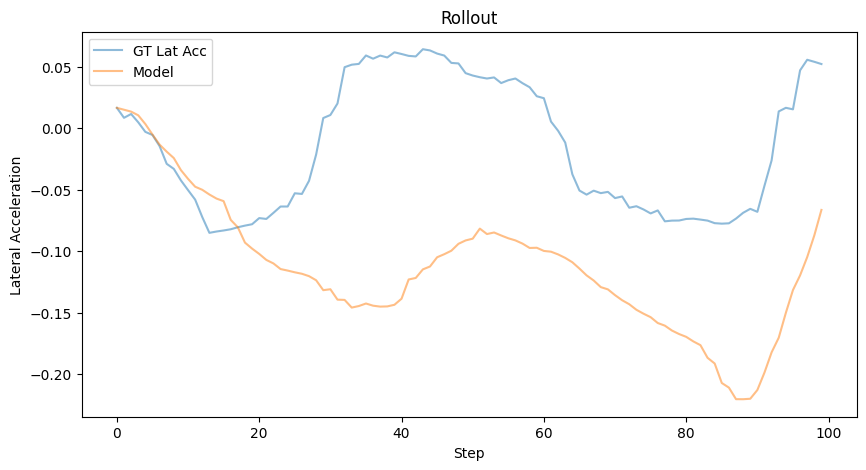

In [59]:
def plot_rollout(rollout, test_data):
  fig, ax = plt.subplots(figsize=(10, 5))
  ax.plot(test_data[:, 3], label="GT Lat Acc", alpha=0.5)
  ax.plot([latacc for latacc in rollout], label="Model", alpha=0.5)
  ax.legend()
  ax.set_xlabel("Step")
  ax.set_ylabel("Lateral Acceleration")
  ax.set_title("Rollout")
  plt.show()

plot_rollout(rollout, test_data)
